In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

Defining ten topic-word distributions:

In [3]:
topic_0 = np.array([ 100,100,100,100,100, 0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0 ])
topic_1 = np.array([ 100,0,0,0,0, 100,0,0,0,0, 100,0,0,0,0, 100,0,0,0,0, 100,0,0,0,0 ])
topic_2 = np.array([ 0,0,0,0,100, 0,0,0,0,100, 0,0,0,0,100, 0,0,0,0,100, 0,0,0,0,100 ])
topic_3 = np.array([ 0,100,0,0,0, 0,100,0,0,0, 0,100,0,0,0, 0,100,0,0,0, 0,100,0,0,0 ])
topic_4 = np.array([ 100,0,0,0,0, 0,100,0,0,0, 0,0,100,0,0, 0,0,0,100,0, 0,0,0,0,100 ])
topic_5 = np.array([ 100,100,100,100,100, 0,0,0,0,100, 0,0,0,0,100, 0,0,0,0,100, 0,0,0,0,100 ])
topic_6 = np.array([ 0,0,0,0,0, 100,100,100,100,100, 0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0 ])
topic_7 = np.array([ 0,0,0,0,0, 0,0,0,0,0, 0,0,0,0,0, 0,0,0,100,100, 0,0,0,100,100 ])
topic_8 = np.array([ 100,100,0,0,0, 100,100,0,0,0, 100,100,0,0,0, 0,0,0,0,0, 0,0,0,0,0 ])
topic_9 = np.array([ 0,0,0,0,0, 0,0,0,0,0, 0,0,100,100,100, 0,0,100,100,100, 0,0,100,100,100])


Rescaling these topic word distributions so they are actually probability distributions

In [4]:
t0_dist = topic_0.reshape(1,-1) / np.sum(topic_0)
t1_dist = topic_1.reshape(1,-1) / np.sum(topic_1)
t2_dist = topic_2.reshape(1,-1) / np.sum(topic_2)
t3_dist = topic_3.reshape(1,-1) / np.sum(topic_3)
t4_dist = topic_4.reshape(1,-1) / np.sum(topic_4)
t5_dist = topic_5.reshape(1,-1) / np.sum(topic_5)
t6_dist = topic_6.reshape(1,-1) / np.sum(topic_6)
t7_dist = topic_7.reshape(1,-1) / np.sum(topic_7)
t8_dist = topic_8.reshape(1,-1) / np.sum(topic_8)
t9_dist = topic_9.reshape(1,-1) / np.sum(topic_9)

In [5]:
tdists = [t0_dist, t1_dist, t2_dist, t3_dist, t4_dist, t5_dist, t6_dist, t7_dist, t8_dist, t9_dist]
tdists = [np.squeeze(item) for item in tdists]
num_topics = len(tdists)

Defining the number of documents (images in this case) and the number of (not necessarily unique) words in each document. The dimension just relates to the size of the image. Each pixel in an image is a possible word, so there are $dim^2$ words in the vocabulary of this example.

In [6]:
num_images = 1000
num_words = 100
dim = 5

Visualizing the topic-word distributions. For example, in the right most topic, words (pixels) come from only the top row.

<Figure size 640x480 with 0 Axes>

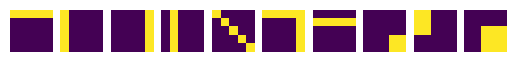

In [7]:
plt.figure()

fig, axes = plt.subplots(1,len(tdists))
for i, t in enumerate(tdists):
    axes[i].imshow(tdists[i].reshape(dim, dim))
    axes[i].axis('off')

This is where I generate synthetic data by, for each document (image), I pick a distribution over topics by drawing from a multinomial distribution. The probabilities associated with each topic form the multinomial topic distribution. I then draw from the multinomial distribution over topics $num_words$ times which gives the frequencies of how many words originating from some topic appear in the document. Then, for each topic, I draw the corresponding number of words for that topic from that topic's topic-word distribution. After this process, I have $num_images \times num_words$ words and their corresponding assignments stored in `w_corp` and `z_corp` respectively.

In [ ]:
w_corp = []
z_corp = []

for iter in range(num_images):
    dir_draw = np.random.dirichlet([1] * num_topics, 1)[0]
    mult_draw = np.random.multinomial(num_words, pvals = dir_draw)
    w_i = np.zeros(num_words)
    z_i = np.zeros(num_words)
    i = 0
    for t, count in enumerate(mult_draw):
        words = np.random.choice(dim * dim, size=count, p=tdists[t])
        for j, word in enumerate(words):
            w_i[i] = words[j]
            z_i[i] = t
            i += 1 
    w_i, z_i = shuffle(w_i, z_i, random_state=0)
    w_corp.append(w_i)
    z_corp.append(z_i)
w_corp = np.array(w_corp)
z_corp = np.array(z_corp)

To give an idea of what the synthetic data looks like, I draw 50 "documents" and show what they look like. The goal is to then recover the topic-word distributions used to generate these, only from the synthetic data. At least to my eye, it is not obvious what the topic-word distributions used to generate these are, only based on the examples shown below.

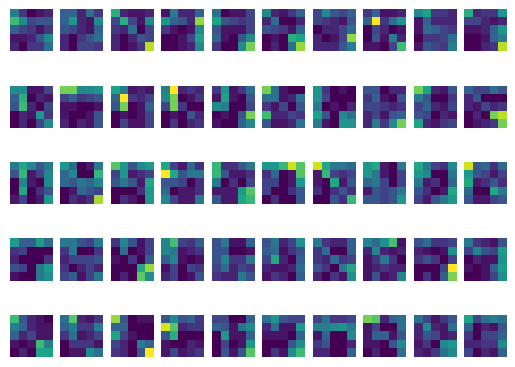

In [9]:
rows = 5
cols = 10

indices = np.random.choice(w_corp.shape[0], rows * cols, replace=False)

indices = indices.reshape(rows, cols)

fig, axes = plt.subplots(rows, cols)

for i, row in enumerate(indices):
    images = w_corp[row]
    maxfreq = 0
    for j, image in enumerate(images):
        unique, counts = np.unique(image, return_counts=True)
        maxfreq = max(maxfreq, max(counts))
    for j, image in enumerate(images):
        unique, counts = np.unique(image, return_counts=True)
        freqs = np.zeros(dim * dim)
        for num, ct in zip(unique, counts):
            freqs[int(num)] = ct
        axes[i,j].imshow(freqs.reshape(dim, dim), vmin=0, vmax=maxfreq)
        axes[i,j].axis("off")

As the first part of the procedure, I generate an initial state of the Markov chain, which initially assigns topics to words randomly. There are $num\_images \times num\_words$ topic assignments in this vector.

In [10]:
topic_assignments = np.random.randint(0,num_topics,size=num_images * num_words)
len(topic_assignments)

100000

In [17]:
topic_assignments = topic_assignments.reshape(num_images, num_words)

These are the parameters of the underlying Dirichlet distributions.

In [18]:
beta = 1
alpha = 1

These two data structures allow me to track $n_j^{(w)}$ and $n_j^{(d)}$ without having to recalculate every time. Using the trick mentioned in Griffiths and Steyvers, one need only increment the entries according to the reassigned word, which is much less costly than recalculating $n_j^{(w)}$ and $n_j^{(d)}$ every iteration.

In [19]:
document_data = np.zeros((num_images, num_topics))
word_data = np.zeros((dim * dim, num_topics))

In this cell I populate the two data structures above for the initial random topic assignment.

In [20]:
for d in range(num_images):
    for w in range(num_words):
        document_data[d, topic_assignments[d,w]] += 1
        word_data[int(w_corp[d,w]), topic_assignments[d,w]] += 1

This function draws from the full conditional distribution on topic assignments, or $p(z_i |\mathbf{z}_{-i}, \mathbf{w})$, as derived in the paper.

In [22]:
def new_draw_fcd(state, ind):
    d = math.floor(ind / num_words)
    w_ind = ind - d * num_words
    word = int(w_corp[d, w_ind])
    topic = state[d, w_ind]

    doc_topic = document_data[d].copy()
    doc_topic[topic] -= 1
    nddot = np.sum(doc_topic)
    doc_topic_dist = (doc_topic + alpha) / (nddot + num_topics * alpha)

    topic_word = word_data[word].copy()
    topic_word[topic] -= 1

    njdot = np.sum(document_data, axis=0)
    topic_word_dist = (topic_word + beta) / (njdot + dim * dim * beta)

    fcd = doc_topic_dist * topic_word_dist

    fcd_rescale = fcd / np.sum(fcd)
    return np.random.choice(num_topics, 1, p=fcd_rescale)[0]

The function corresponds to one iteration of gibbs sampling.

In [2]:
def gibbs_iter(w_corp, state):
    for i in range(num_words * num_images):
        d = math.floor(i / num_words)
        w_ind = i - d * num_words
        old_topic = state[d,w_ind].copy()
        new_state_i = new_draw_fcd(state, i)
        word = int(w_corp[d,w_ind])
        state[d,w_ind] = new_state_i
        
        document_data[d, old_topic] -=1
        document_data[d, new_state_i] +=1

        word_data[word, old_topic] -=1
        word_data[word, new_state_i] += 1

    return state.reshape(num_images, num_words)

Here, I run Gibbs sampling for 1000 iterations, starting from the initially random topic assignments.

In [31]:
state = topic_assignments
for i in range(1000):
    if i % 100 == 0:
        print(i)
    state = gibbs_iter(w_corp, topic_assignments)

0
100
200
300
400
500
600
700
800
900


This calculates an estimate of each topic-word distribution $\phi_j$ for a topic $j$

In [32]:
def calc_phi(words, z_hat, t):
    tprobs = np.zeros(dim * dim)
    words_in_topic = words.reshape(1,-1)[z_hat.reshape(1,-1) == t]
    unique, counts = np.unique(words_in_topic, return_counts=True)
    njdot = np.sum(counts)
    for word in range(dim * dim):
        numerator = beta
        denom = dim * dim * beta + njdot
        if word in unique:
            numerator += counts[np.where(unique == word)][0]
        tprobs[word] = numerator / denom
    return tprobs.reshape(dim, dim)
        

Using the state vector after 1000 iterations of gibbs sampling, I calculate $\phi_j$ for each topic $j$. It appears that this does a pretty good job at recovering the initial topic-word distributions. 

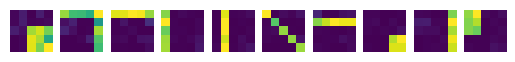

In [33]:
fig, ax = plt.subplots(1, num_topics)

for t in range(num_topics):
     ax[t].imshow(calc_phi(w_corp, state, t))
     ax[t].axis("off")